In [12]:
import gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
import pickle
from nltk.corpus import stopwords
#use wordnet lemmatizor, gensims lemmatizer is deactivated
from nltk.stem import WordNetLemmatizer
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [2]:
#Need to add nltk stop_words
stop_words = set(stopwords.words('english'))

In [3]:
#read in file
with open('../data/data_simple_preprocess/cf_kv_tokenized_simple_preprocess_sw_removed.txt', 'rb') as file:
    cf_kv_tokenized_simple_preprocess_sw_removed = pickle.load(file)

In [4]:
cf_kv_tokenized_simple_preprocess_sw_removed.keys()

dict_keys(['Address of Tatian to the Greeks', 'Athenagoras the Athenian', 'Clement of Alexandria Exhortation to the Heathen', 'Clement of Alexandria The Salvation of the Rich Man', 'Clement of Alexandria Trilogy', 'Clement of Alexandria, The Stromata', 'Dialogue of Justin, Philosopher and Martyr, with Trypho, a Jew', 'Epistle of Adrian Antoninus and Marcus Aurelius', 'Epistle of Clement of Rome', 'False Ignatius', 'Fragments of Papias', 'Fragments of the Lost Work of Justin on the Resurrection', 'Hippolytus of Rome Expository Treatise Against The Jews.', 'Hippolytus of Rome Treatise On Christ and Antichrist', 'Igantius Syriac Epistles', 'Ignatius Other', 'Ireanaus Against Heresies Book III', 'Ireanaus Fragments from the Lost Writings', 'Irenaeus Against Heresies Book I', 'Irenaeus Against Heresies Book II', 'Irenaeus Against Heresies Book V', 'Ireneaus Against Heresies Book IV', "Justin's Hortatory Address to the Greeks", 'Origen', 'Tertullian', 'The Didache', 'The Epistle of Barnabas'

In [5]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(cf_kv_tokenized_simple_preprocess_sw_removed.values(), min_count=5, threshold=50) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[cf_kv_tokenized_simple_preprocess_sw_removed.values()], threshold=50)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[list(cf_kv_tokenized_simple_preprocess_sw_removed.values())[0]]])


['address', 'tatian', 'greeks', 'chapter', 'the', 'greeks', 'claim', 'without', 'reason', 'invention', 'arts', 'be', 'not', 'greeks', 'hostilely', 'disposed', 'barbarians', 'look', 'ill', 'opinions', 'for', 'institutions', 'derived', 'barbarians', 'the', 'eminent', 'telmessians', 'invented', 'art', 'divining', 'dreams', 'carians', 'prognosticating', 'stars', 'phrygians', 'ancient', 'isaurians', 'augury', 'flight', 'birds', 'cyprians', 'art', 'inspecting', 'victims', 'to', 'babylonians', 'owe', 'astronomy', 'persians', 'magic', 'egyptians', 'geometry', 'phoenicians', 'instruction', 'alphabetic', 'writing', 'cease', 'then', 'miscall', 'imitations', 'inventions', 'own', 'orpheus', 'again', 'taught', 'poetry', 'song', 'him', 'too', 'learned', 'mysteries', 'the', 'tuscans', 'taught', 'plastic', 'art', 'annals', 'egyptians', 'learned', 'write', 'history', 'acquired', 'art', 'playing', 'flute', 'marsyas', 'olympus', 'these', 'rustic', 'phrygians', 'constructed', 'harmony', 'shepherd', 'pipe',

In [6]:
trigram_mod

In [18]:
# Create Dictionary and run LDA
id2word = corpora.Dictionary(cf_kv_tokenized_simple_preprocess_sw_removed.values())

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in cf_kv_tokenized_simple_preprocess_sw_removed.values()]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

print(lda_model.print_topics())

[(0, '0.017*"god" + 0.011*"he" + 0.009*"and" + 0.009*"things" + 0.008*"the" + 0.007*"for" + 0.006*"his" + 0.006*"him" + 0.006*"but" + 0.005*"man"'), (1, '0.000*"god" + 0.000*"pompeianus" + 0.000*"granianus" + 0.000*"bidentalis" + 0.000*"battalion" + 0.000*"certifies" + 0.000*"cohorts" + 0.000*"nyss" + 0.000*"antonin" + 0.000*"complement"'), (2, '0.019*"ye" + 0.017*"literally" + 0.016*"christ" + 0.015*"jesus" + 0.011*"love" + 0.011*"bishop" + 0.007*"let" + 0.007*"comp" + 0.007*"chapter" + 0.007*"worthy"'), (3, '0.001*"superfluities" + 0.001*"finery" + 0.000*"courtesans" + 0.000*"revelry" + 0.000*"thersites" + 0.000*"colts" + 0.000*"instructor" + 0.000*"amatory" + 0.000*"feminino" + 0.000*"crazy"'), (4, '0.011*"for" + 0.010*"and" + 0.009*"god" + 0.008*"he" + 0.008*"the" + 0.006*"but" + 0.006*"says" + 0.005*"man" + 0.005*"lord" + 0.004*"good"'), (5, '0.020*"god" + 0.015*"and" + 0.014*"he" + 0.012*"lord" + 0.011*"shall" + 0.010*"the" + 0.009*"him" + 0.009*"said" + 0.009*"his" + 0.009*"for"

In [19]:
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.017*"god" + 0.011*"he" + 0.009*"and" + 0.009*"things" + 0.008*"the" + 0.007*"for" + 0.006*"his" + 0.006*"him" + 0.006*"but" + 0.005*"man"'), (1, '0.000*"god" + 0.000*"pompeianus" + 0.000*"granianus" + 0.000*"bidentalis" + 0.000*"battalion" + 0.000*"certifies" + 0.000*"cohorts" + 0.000*"nyss" + 0.000*"antonin" + 0.000*"complement"'), (2, '0.019*"ye" + 0.017*"literally" + 0.016*"christ" + 0.015*"jesus" + 0.011*"love" + 0.011*"bishop" + 0.007*"let" + 0.007*"comp" + 0.007*"chapter" + 0.007*"worthy"'), (3, '0.001*"superfluities" + 0.001*"finery" + 0.000*"courtesans" + 0.000*"revelry" + 0.000*"thersites" + 0.000*"colts" + 0.000*"instructor" + 0.000*"amatory" + 0.000*"feminino" + 0.000*"crazy"'), (4, '0.011*"for" + 0.010*"and" + 0.009*"god" + 0.008*"he" + 0.008*"the" + 0.006*"but" + 0.006*"says" + 0.005*"man" + 0.005*"lord" + 0.004*"good"'), (5, '0.020*"god" + 0.015*"and" + 0.014*"he" + 0.012*"lord" + 0.011*"shall" + 0.010*"the" + 0.009*"him" + 0.009*"said" + 0.009*"his" + 0.009*"for"

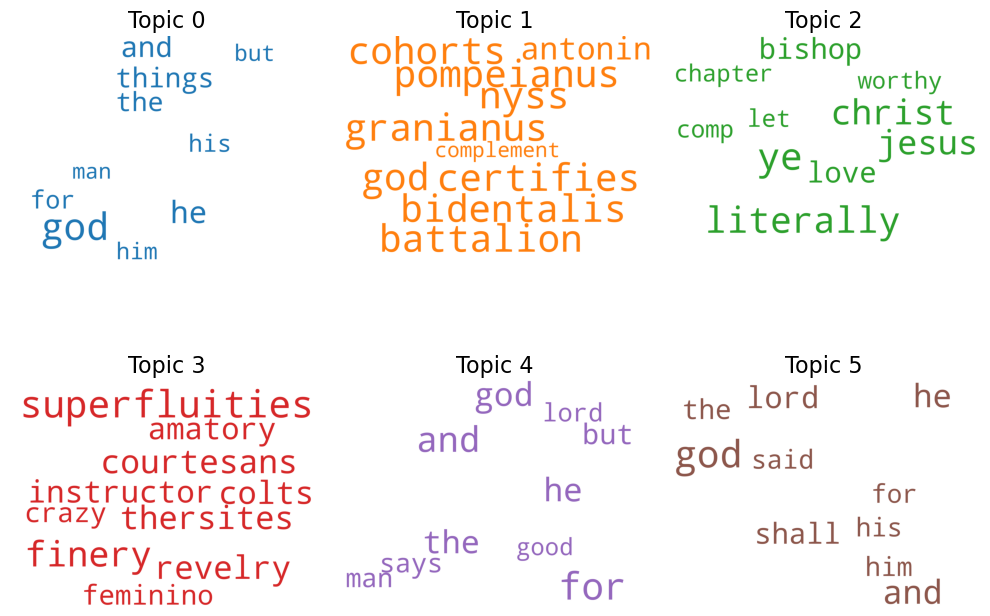

In [20]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 3, figsize=(10,8), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [21]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word, mds='mmds')
pyLDAvis.display(vis)

C:\Users\micha\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
